In [ ]:

import os
os.chdir('/project/nanocourse/SWE_OOP/train03/se/Module_2_Materials/mod2/HPO')
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

try:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    gpus = tf.config.list_physical_devices("GPU")
    print(gpus)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3300)]
    )
except:
    Warning("Unable To configure Tensorflow GPU")

from vaegan.data import MNIST
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.callbacks import GenerateImagesConditional, SaveImagesConditional

2025-05-30 08:28:13.793751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748611693.816785   51758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748611693.823859   51758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748611693.841908   51758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748611693.841927   51758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748611693.841929   51758 computation_placer.cc:177] computation placer alr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
data = MNIST()
train_images = data.images_train
train_labels = data.labels_train
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()

n_latent_dims = 32
learning_rate = 1e-3
conv_layer_kernel_size = 4
output_dir = f'outputs/hpo_cvae_gridSearch/optimal_model'
if os.path.exists(output_dir)==False:
    os.mkdir(output_dir)

nEpochs = 10
hpo_params = {
    'n_latent_dims' : n_latent_dims,    # latent space dimension
    'learning_rate': learning_rate, #learning gradient steps
    'encoder_params' : {
        'conv_layer_units' : [16,64],   #filter number for each layer
        'conv_layer_kernel_size' : [conv_layer_kernel_size]*2,   # kernel size for each layer
        'conv_layer_strides' : [(1,1), (2,2)],  # kernel strides, higher values represent higher efficiency but lower details
        'conv_layer_activation_function' : ['relu','relu'], 
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },
    'decoder_params' : {'conv_layer_units' : [16,64],
        'conv_layer_kernel_size' : [conv_layer_kernel_size]*2,
        'conv_layer_strides' : [(1,1), (2,2)],
        'conv_layer_activation_function' : ['relu','relu'],
        'encoder_dense_layer_units' : [128],
        'decoder_dense_layer_units' : [],
    },}

tf.random.set_seed(1234)
model = ConditionalVAE(n_classes=n_classes, 
                        n_latent_dims = hpo_params['n_latent_dims'],
                        encoder_params = hpo_params['encoder_params'],
                        decoder_params = hpo_params['decoder_params'],
)

enc_in = tf.keras.layers.Input((32,32,1 + model.n_classes)) # 32x32x1 + 10 more in the last dim for the one-hot encoded class label
enc_out  = model.encoder.call(enc_in) 
enc = tf.keras.Model(enc_in, enc_out) 
# enc.summary()
# print("=== DECODER SUBMODEL ====")
dec_in = tf.keras.layers.Input((model.n_latent_dims+model.n_classes,)) 
dec_out  = model.decoder.call(dec_in) 
dec = tf.keras.Model(dec_in, dec_out) 
# dec.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hpo_params['learning_rate']), run_eagerly=True)

# Fit model to the data
save_images_callback = SaveImagesConditional(output_dir=output_dir, 
                                                model=model,
                                                example_images=data.images_train[:10],
                                                example_labels=labels_onehot[:10],
                                                n_generated_images=10,
                                                n_latent_dims=model.n_latent_dims)

logs = model.fit([data.images_train, labels_onehot],
                batch_size=128,
                epochs=nEpochs,
                callbacks=[save_images_callback])

Loaded version: vaegan.vae_SOLUTIONS
Loaded version: vaegan.vae_SOLUTIONS
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 122s 260ms/step - kl_loss: 110.3355 - recon_loss: 68.9533 - total_loss: 179.2888
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 123s 261ms/step - kl_loss: 12.1488 - recon_loss: 24.9434 - total_loss: 37.0922
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 122s 260ms/step - kl_loss: 11.5929 - recon_loss: 20.9244 - total_loss: 32.5174
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 122s 260ms/step - kl_loss: 11.2748 - recon_loss: 18.9877 - total_loss: 30.2625
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 122s 261ms/step - kl_loss: 11.0562 - recon_loss: 17.8700 - total_loss: 28.9262
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 253ms/step - kl_loss: 10.9333 - recon_loss: 17.2017 - total_loss: 28.1349
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 249ms/step - kl_loss: 10.8669 - recon_loss: 16.8074 - total_loss: 27.6743
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 113s 240ms/step - kl_loss: 10.8570 - recon_loss: 16

In [11]:
encoder = model.encoder


In [12]:
from vaegan.vae_SOLUTIONS import sample_from_normal

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices((data.images_train, labels_onehot))
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

all_z_mean = []
all_z_logvar = []
all_z_sampled = []

for i, (batch_images, batch_labels_onehot) in enumerate(dataset):
    encoder_inputs_batch = model.make_conditional_input(batch_images, batch_labels_onehot)
    z_mean_batch, z_logvar_batch = model.encoder(encoder_inputs_batch, training=False)
    z_sampled_batch = sample_from_normal(z_mean_batch, z_logvar_batch)

    all_z_mean.append(z_mean_batch.numpy())
    all_z_logvar.append(z_logvar_batch.numpy())
    all_z_sampled.append(z_sampled_batch.numpy())

    if (i + 1) % 100 == 0:
        print(f"  Processed batch {i + 1}")

print(f"  Finished processing all batches.")

z_mean = np.concatenate(all_z_mean, axis=0)
z_logvar = np.concatenate(all_z_logvar, axis=0)
z_sampled = np.concatenate(all_z_sampled, axis=0)

  Processed batch 100
  Processed batch 200
  Processed batch 300
  Processed batch 400
  Finished processing all batches.


In [15]:
z_sampled.shape

(60000, 4)

In [16]:
z_mean.shape


(60000, 4)

In [17]:
train_labels.shape

(60000,)

<Axes: xlabel='x', ylabel='y'>

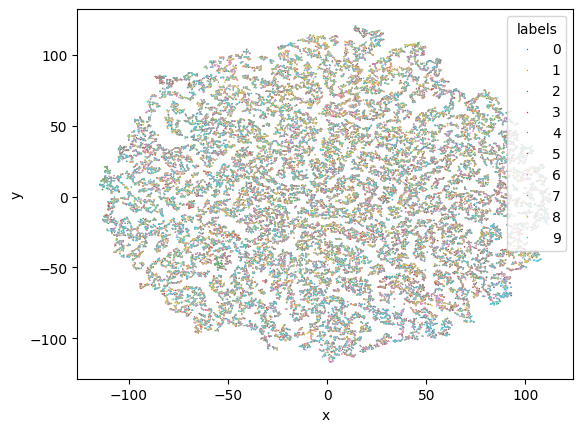

In [28]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd

X = z_sampled
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
tsne = TSNE().fit_transform(X_norm)

img = pd.DataFrame(tsne)
img.columns = ['x', 'y']
img['labels'] = train_labels.astype(str)
img = img.sort_values(by='labels')
sns.scatterplot(data=img, x='x', y='y', hue='labels', s=1)


<Axes: xlabel='x', ylabel='y'>

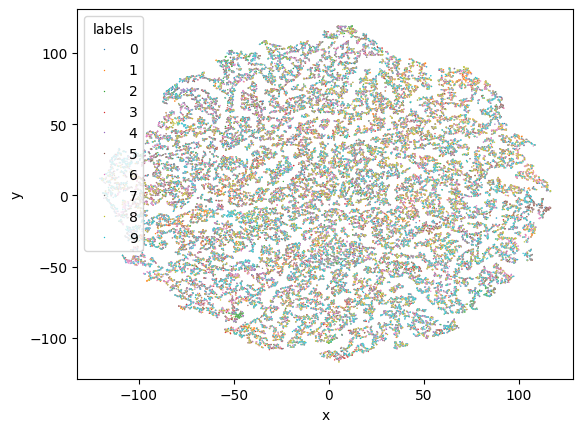

In [25]:
X = z_mean
tsne = TSNE().fit_transform(X)

img = pd.DataFrame(tsne)
img.columns = ['x', 'y']
img['labels'] = train_labels.astype(str)
img = img.sort_values(by='labels')
sns.scatterplot(data=img, x='x', y='y', hue='labels', s=1)

/project/nanocourse/SWE_OOP/train03/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

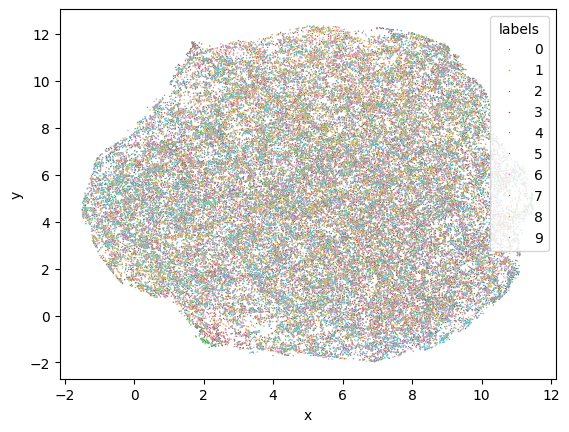

In [26]:
import umap

X = z_sampled
tsne = umap.UMAP().fit_transform(X)

img = pd.DataFrame(tsne)
img.columns = ['x', 'y']
img['labels'] = train_labels.astype(str)
img = img.sort_values(by='labels')
sns.scatterplot(data=img, x='x', y='y', hue='labels', s=1)

/project/nanocourse/SWE_OOP/train03/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='x', ylabel='y'>

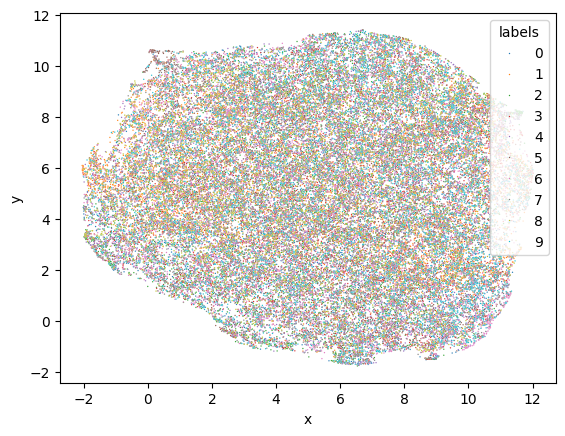

In [27]:
X = z_mean
tsne = umap.UMAP().fit_transform(X)

img = pd.DataFrame(tsne)
img.columns = ['x', 'y']
img['labels'] = train_labels.astype(str)
img = img.sort_values(by='labels')
sns.scatterplot(data=img, x='x', y='y', hue='labels', s=1)